# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [1]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 5#experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


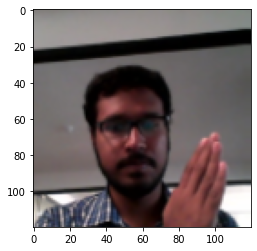

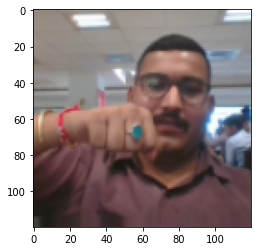

In [4]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
## Test code start
# 360 by 360
# image1 = imageio.imread('/content/drive/MyDrive/Project_data/val/WIN_20180926_17_56_52_Pro_Right_Swipe_new/WIN_20180926_17_56_52_Pro_00021.png')
image1 = imread('/home/datasets/Project_data/val/WIN_20180907_15_30_06_Pro_Right Swipe_new/WIN_20180907_15_30_06_Pro_00015.png')
image2 = imread('/home/datasets/Project_data/val/WIN_20180907_15_38_42_Pro_Thumbs Up_new/WIN_20180907_15_38_42_Pro_00007.png')
#crop the images and resize them. Note that the images are of 2 different shape
#and the conv3D will throw error if the inputs in a batch have different shapes
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)
plt.imshow(image2)
plt.show()
## Test code end


def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        
        


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [6]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]

In [7]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

In [8]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

from keras.regularizers import l2

#write your model here

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [10]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

In [11]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120
num_classes = 5 

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                              

2024-01-04 13:53:47.971769: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-01-04 13:53:47.971859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [12]:
callbacks_list = model_callbacks("model_conv3D_1")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)
train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                             callbacks=callbacks_list, validation_data=val_generator,
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_495/1552239351.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/25


2024-01-04 13:53:54.730213: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5176 - categorical_accuracy: 0.4540
Epoch 00001: val_loss improved from inf to 3.49960, saving model to model_conv3D_1_2024-01-0413_53_47.002369/model-00001-1.51758-0.45400-3.49960-0.17000.h5
67/67 [==============================] - 298s 4s/step - loss: 1.5176 - categorical_accuracy: 0.4540 - val_loss: 3.4996 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0342 - categorical_accuracy: 0.6063
Epoch 00002: val_loss did not improve from 3.49960
67/67 [==============================] - 323s 5s/step - loss: 1.0342 - categorical_accuracy: 0.6063 - val_loss: 3.8415 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.7577 - categorical_accuracy: 0.7164
Epoch 00003: val_loss did not improve from 3.49960
67/67 [==============================] - 293s 4s/step - loss: 0.7577 - categorical_accuracy: 0.7164 -

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


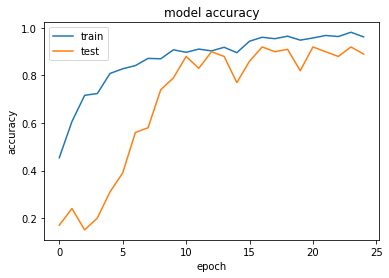

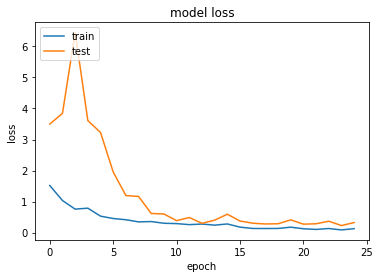

In [14]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [12]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120
num_classes = 5 
model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_6 (Activation)   (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

In [13]:
callbacks_list = model_callbacks("model_conv3D_2")
steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)
train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)
val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [14]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_320/3067023477.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2024-01-05 01:56:03.897480: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


67/67 [==============================] - ETA: 0s - loss: 1.5300 - categorical_accuracy: 0.4495
Epoch 00001: val_loss improved from inf to 5.57588, saving model to model_conv3D_2_2024-01-0501_14_15.406323/model-00001-1.53001-0.44947-5.57588-0.16000.h5
67/67 [==============================] - 134s 2s/step - loss: 1.5300 - categorical_accuracy: 0.4495 - val_loss: 5.5759 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9104 - categorical_accuracy: 0.6320
Epoch 00002: val_loss improved from 5.57588 to 5.33413, saving model to model_conv3D_2_2024-01-0501_14_15.406323/model-00002-0.91045-0.63198-5.33413-0.18000.h5
67/67 [==============================] - 128s 2s/step - loss: 0.9104 - categorical_accuracy: 0.6320 - val_loss: 5.3341 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.6504 - categorical_accuracy: 0.7587
Epoch 00003: val_loss did not improve from 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


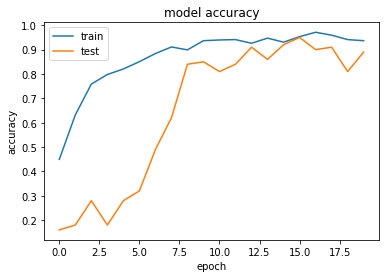

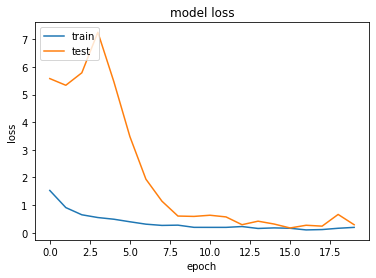

In [ ]:
plot_loss_accuracy(history)